# Rain in Australia

Esse projeto é para fazer um modelo de predição para previsão do tempo para o proxímo dia na Australia, se vai chover ou não, através de um resultado binário em um sistema treinado.

### Conteúdo

Esse dataset contem dados de dias obeservados e registrados por diversas estações meteorológicas da Australia. 

O objetivo é a variável **RainTomorrow**, que reponde a pergunta: "Vai chover amanhã? Sim ou Não".

### Fontes

Essa fonte de dados se encontra na plataforma Kaggle em: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package/home.
Para mais detalhes para a fonte de dados acesse o link.

### Imports

In [1]:
# Para exploração de dados
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Para escalonamento dos valores
from scipy import stats

# Para o sistema de predição
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import preprocessing

# para o sistema de validação
from sklearn.metrics import accuracy_score, precision_score, recall_score
from numpy import mean
import sys


### Análise de dados

Primeiramente vamos acessar os dados e visualizar o dataframe.

In [2]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [3]:
# Visuzalizar as dimeções do dataframe.
df.shape

(142193, 24)

Por orientação da fonte vamos retirar a coluna "RISK_MM". O motivo é dado aqui https://www.kaggle.com/jsphyg/weather-dataset-rattle-package/discussion/78316.

In [4]:
# Removendo a coluna "RISK_MM" e vizualizando a novas dimensões.
df = df.drop(columns='RISK_MM')
df.shape

(142193, 23)

Vizualizando as informações sobre os dados, como quantidade em cada coluna e o formato.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
Date             142193 non-null object
Location         142193 non-null object
MinTemp          141556 non-null float64
MaxTemp          141871 non-null float64
Rainfall         140787 non-null float64
Evaporation      81350 non-null float64
Sunshine         74377 non-null float64
WindGustDir      132863 non-null object
WindGustSpeed    132923 non-null float64
WindDir9am       132180 non-null object
WindDir3pm       138415 non-null object
WindSpeed9am     140845 non-null float64
WindSpeed3pm     139563 non-null float64
Humidity9am      140419 non-null float64
Humidity3pm      138583 non-null float64
Pressure9am      128179 non-null float64
Pressure3pm      128212 non-null float64
Cloud9am         88536 non-null float64
Cloud3pm         85099 non-null float64
Temp9am          141289 non-null float64
Temp3pm          139467 non-null float64
RainToday        140787 non-null obje

Após fazer um análise das colunas através de **value.counts**, função que não seram exibidos por consumir muito espaço, vamos remover as seguinte colunas:

* Location: A pergunta é se vai chover amanhã, portanto a localidade não tem muita relevância para a pergunta.
* Date: As datas são aleatórias, o mais importante é que possuem uma função de índice para as características de um determinado dia.
* Evaporation, Sunshine, Cloud9am e Cloud3pm : eles possuem muito valores nulos e por terem algumas uma escala muito alta, não é viável para preenchê-los.    

### Tratamento dos dados

Vamos começar com a remoção das colunas de característics que não vão ser úteis para os modelos preditivos:

In [6]:
df = df.drop(columns=['Location','Date', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 17 columns):
MinTemp          141556 non-null float64
MaxTemp          141871 non-null float64
Rainfall         140787 non-null float64
WindGustDir      132863 non-null object
WindGustSpeed    132923 non-null float64
WindDir9am       132180 non-null object
WindDir3pm       138415 non-null object
WindSpeed9am     140845 non-null float64
WindSpeed3pm     139563 non-null float64
Humidity9am      140419 non-null float64
Humidity3pm      138583 non-null float64
Pressure9am      128179 non-null float64
Pressure3pm      128212 non-null float64
Temp9am          141289 non-null float64
Temp3pm          139467 non-null float64
RainToday        140787 non-null object
RainTomorrow     142193 non-null object
dtypes: float64(12), object(5)
memory usage: 18.4+ MB


Agora temos uma quantidade de valores mais parecidas entre todas as colunas.

In [7]:
# Vizualizando as novas dimensões do dataframe.
df.shape

(142193, 17)

Removendo valores nulos, que são inviáveis para um sistema de predição, e conferindo se não afetou as dimensões essa remoção.

In [8]:
df = df.dropna(how='any')
df.shape

(112925, 17)

Verificando se os dados possuem outliers com blockspot de algumas colunas.

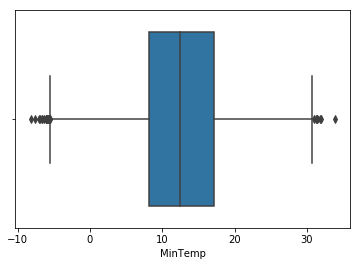

In [10]:
# Gerando os gráficos blokspot.
sns.boxplot(x=df['MinTemp'])
plt.show()

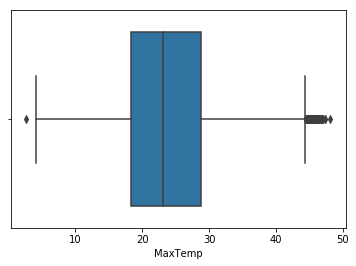

In [11]:
sns.boxplot(x=df['MaxTemp'])
plt.show()

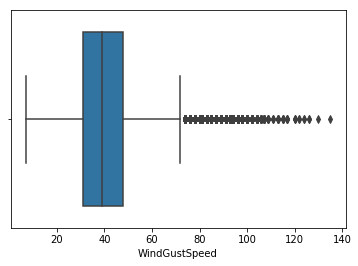

In [12]:
sns.boxplot(x=df['WindGustSpeed'])
plt.show()

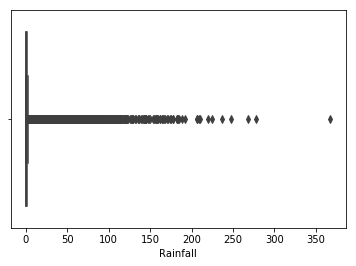

In [13]:
sns.boxplot(x=df['Rainfall'])
plt.show()

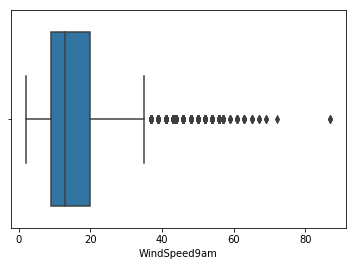

In [14]:
sns.boxplot(x=df['WindSpeed9am'])
plt.show()

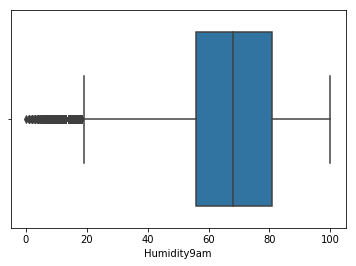

In [15]:
sns.boxplot(x=df['Humidity9am'])
plt.show()

Um exemplo da existência de outliers está no gráfico de  **Humidity9am** temos exemplos de outliers bem claros, valores de humidade proximo de 0 ou 100 são condições extremas, quase impossíveis de exitir.

Vamos remover os outliers usando a tecnica Z-score. Essa técnica faz o escalonamento de todos os valores do dataframe e os relaciona com a média e o desfio padrão, gerando um score para cada valor. O valor da média é 0 e os que estão dentro de uma faixa normal de desvio padrão estão entre 1 e -1. Assim os valores que tiverem scores próximos de 3 e -3 são considerados outliers, podendo ser removidos do dataframe.

In [16]:
# Apicando o escalinamento dos dados somente númericos, por isso o "get_numeric_data".
z = np.abs(stats.zscore(df._get_numeric_data()))
# Retornando a tabela com os valores z
print(z)
# Removendo os outliers
df= df[(z < 3).all(axis=1)]
# Obtendo as novas dimensões do dataframe
print(df.shape)

[[0.11756741 0.10822071 0.20666127 ... 1.14245477 0.08843526 0.04787026]
 [0.84180219 0.20684494 0.27640495 ... 1.04184813 0.04122846 0.31776848]
 [0.03761995 0.29277194 0.27640495 ... 0.91249673 0.55672435 0.15688743]
 ...
 [1.44940294 0.23548728 0.27640495 ... 0.58223051 1.03257127 0.34701958]
 [1.16159206 0.46462594 0.27640495 ... 0.25166583 0.78080166 0.58102838]
 [0.77784422 0.4789471  0.27640495 ... 0.2085487  0.37167606 0.56640283]]
(107868, 17)


Conferindo a quantidade de dados que vamos ultilizar para os modelos preditivos.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107868 entries, 0 to 142192
Data columns (total 17 columns):
MinTemp          107868 non-null float64
MaxTemp          107868 non-null float64
Rainfall         107868 non-null float64
WindGustDir      107868 non-null object
WindGustSpeed    107868 non-null float64
WindDir9am       107868 non-null object
WindDir3pm       107868 non-null object
WindSpeed9am     107868 non-null float64
WindSpeed3pm     107868 non-null float64
Humidity9am      107868 non-null float64
Humidity3pm      107868 non-null float64
Pressure9am      107868 non-null float64
Pressure3pm      107868 non-null float64
Temp9am          107868 non-null float64
Temp3pm          107868 non-null float64
RainToday        107868 non-null object
RainTomorrow     107868 non-null object
dtypes: float64(12), object(5)
memory usage: 14.8+ MB


Agora vamos tratar os valores categóricos de direção dos ventos (**WindGustDir, WindDir3pm, WindDir9am**). Convertendo as categorias de ventos para valores da quantidade de categorias possíveis.

Achando a quantidade de colunas vão ser criadas por cada coluna de vento.

In [18]:
len(df.WindGustDir.value_counts())

16

Convertendo as colunas para dummies.

In [19]:
# Listando os nomes das colunas
winds = ['WindGustDir', 'WindDir3pm', 'WindDir9am']
    
# Transformando as categorias em valores com "get_dummies"
df = pd.get_dummies(df, columns=winds)

# Verificando a nova dimensão do dataframe
df.shape

(107868, 62)

Agora temos mais 48 colunas substituindo as 3 colunas sobre ventos, dando 62 colunas. Porém para fins matemáticos temos que excluir umas cas colunas de cada vento para que os valores sejam independentes.

In [20]:
# Removendo um coluna de cada categoria convertida.
df = df.drop(['WindGustDir_WSW', 'WindDir3pm_SSW', 'WindDir9am_NNE'], axis =1)
df.shape

(107868, 59)

Convertendo os valores das colunas **RainToday e RainTomorrow** para os valore 0 e 1 para o sistema de resposta de predição binário.

In [21]:
df['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

Conferindo a transformação.

In [22]:
df.RainToday.value_counts()

0    85431
1    22437
Name: RainToday, dtype: int64

In [23]:
df.RainTomorrow.value_counts()

0    85475
1    22393
Name: RainTomorrow, dtype: int64

A última estapa do tratamento foi fazer o escalonamento de todos os valores para ficarem entre 0 e 1. Isso ajudará nos valores como presão (unidades de milhares) e temperatura (unidade de dezenas) não distorçam os modelos, já que tem proporções diferentes. Esse escalonamento não altera as diferenças entre os valores na mesma categoria. 

In [24]:
# Modificando a escala dos nosso valores para deixalos mais parecidos
# Chamando a função de escalonamento "MinMaxScale"
scaler = preprocessing.MinMaxScaler()
# Treinando no nosso sistema
scaler.fit(df)
# Tranformando os dados do dataframe
df = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
# retornando a amostra do nosso sistema
df.iloc[4:10]

C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
4,0.628342,0.696296,0.035714,0.465753,0.135135,0.428571,0.797753,0.33,0.342043,0.282974,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.550802,0.632099,0.007143,0.671233,0.459459,0.523810,0.494382,0.23,0.304038,0.268585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,0.542781,0.516049,0.000000,0.589041,0.486486,0.523810,0.426966,0.19,0.313539,0.335731,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.366310,0.558025,0.000000,0.383562,0.108108,0.357143,0.415730,0.19,0.403800,0.381295,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.419786,0.686420,0.000000,1.000000,0.135135,0.619048,0.348315,0.09,0.296912,0.225420,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.510695,0.641975,0.050000,0.287671,0.351351,0.214286,0.528090,0.27,0.251781,0.275779,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Modelos preditivos

A primeira estapa do processo vai ser determinar quais são as colunas (vou vomeçar a chamar de features daqui para frente, termo usado em inglês) tem maior relevância para o medelo preditivo. Para isso vou aplicar a ferramenta **SelectKBest** para gerar uma pontuação (score) das features para ver quais são mais relevantes. 

Outra mudança vai ser chamar os resultados da predição de labels, que é o objetivos dos modelos, determinar se chove ou não amanhã.

In [55]:
# Separando os dados entre features com X e labels como y. 
X = df.loc[:,df.columns!='RainTomorrow']
y = df[['RainTomorrow']]
# Chamando a função SelectKBest e determinando os parametros de features do nosso dataframe, K = 58
selector = SelectKBest(chi2, k=58)
# Treinando
selector.fit(X, y)
# Retornando os scores
scores = selector.scores_
# Criando uma lista com os nomes das colunas
lista = df.columns
lista = [x for x in lista if x != 'RainTomorrow']
# Convertenando a lista e o scores para um dictionary 
unsorted_pairs = zip(lista, scores)
sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
k_best_features = dict(sorted_pairs[:58])

Gerando um gráfico para visualizar melhor o scores de cada feature.

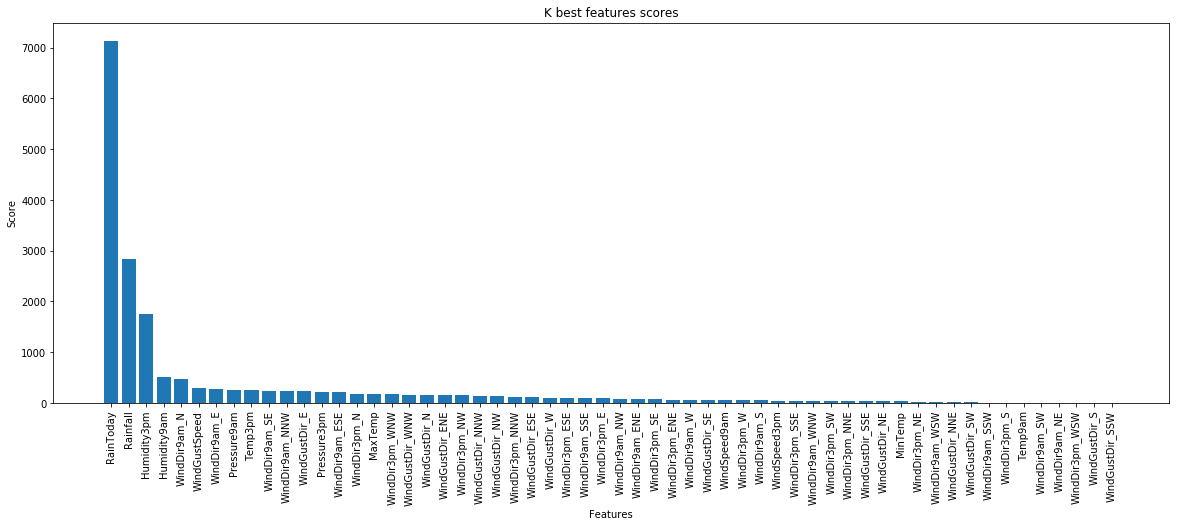

In [54]:
# Plotando a área do gráfico
plt.figure(figsize=(20,7),facecolor = 'w',edgecolor = 'w')
# O gráfico
p = plt.bar(range(len(k_best_features)), list(k_best_features.values()), align='center')
plt.xticks(range(len(k_best_features)), list(k_best_features.keys()))
# Editando os nomes
plt.xticks(rotation='90')
plt.title('K best features scores')
plt.xlabel('Features')
plt.ylabel('Score')
plt.show()

Aqui podemos ver que a featurer com mais relevancia é a **RainToday**. As que tem menor relevancia são algumas de direção do vento. Vamos usar só as features que tiveram o peso acima de 1% da maior (71 pontos), que no caso é a **RainToday** com 7136.

In [29]:
# Criando um lista com os nomes da features que tem score acima de 71.
K_values = []
for key in k_best_features:
    if float(k_best_features[key]) >= float(0.01 * k_best_features['RainToday']):
        K_values.append(key)

['RainToday',
 'Rainfall',
 'Humidity3pm',
 'Humidity9am',
 'WindDir9am_N',
 'WindGustSpeed',
 'WindDir9am_E',
 'Pressure9am',
 'Temp3pm',
 'WindDir9am_SE',
 'WindDir9am_NNW',
 'WindGustDir_E',
 'Pressure3pm',
 'WindDir9am_ESE',
 'WindDir3pm_N',
 'MaxTemp',
 'WindDir3pm_WNW',
 'WindGustDir_WNW',
 'WindGustDir_N',
 'WindGustDir_ENE',
 'WindDir3pm_NW',
 'WindGustDir_NNW',
 'WindGustDir_NW',
 'WindDir3pm_NNW',
 'WindGustDir_ESE',
 'WindGustDir_W',
 'WindDir3pm_ESE',
 'WindDir9am_SSE',
 'WindDir3pm_E',
 'WindDir9am_NW',
 'WindDir9am_ENE']

Separando os dados para aplicar nos modelos de predição.

In [30]:
df_predi = df[K_values + ['RainTomorrow']]
X = df[K_values]
y = df['RainTomorrow']

Depois de selecionado as melhores features, vamos avaliar com quantas features os medelos de decisão vão trabalhar melhor.
Vamos usar os seguintes modelos de predição:

* Logistic Regression
* Decision Tree
* Kmeans


In [32]:
# Cirando uma lista para contagens de features de K_values, no caso 31
n_features_list = list(range(2,len(K_values)+1))

Embora tenhamos escolhido as melhores features para os modelos, vamos ainda avaliar com quantas features o sistema trabalha obtendo os melhores resultados, para isso vamos criar um loop para os modelos retornando a accuracy dos resultados. Para cada interação vai ser retirado a feature que tem o menor score.

In [33]:
# Criando listas para armazernar os resultados de cada modelo
# Para Logistic Regression
accuracy_LR=[]
# Para Decision Tree
accuracy_dt=[]
# Para Kmeans
accuracy_Kmeans=[]

# Criando o loop on n é o número de features na lista contadore de features
for n in n_features_list:  
    
    # Separando os valores para os conjuntos de treinamento e teste com "train_test_split", vamos deixar 20% dos dados
    # para teste e o resto para treinamento.
    features_train, features_test, labels_train, labels_test = train_test_split(df[K_values[:n]], y, test_size=0.2, random_state=42)

    # Chamando a função do método de Logistic Regression
    l_clf = LogisticRegression()
    # Treinando
    l_clf.fit(features_train, labels_train)
    # Fazendo a predição com o grupo de valores de teste
    prediction_lr = l_clf.predict(features_test)
    # Armazenando o valor da accuracy na lista
    accuracy_LR.append(accuracy_score(labels_test, prediction_lr))
    
    # Os mesmos passos são apicados para os outros dois métodos, na mesma ordem
    
    # Para Decision Tree
    dt_clf = DecisionTreeClassifier(random_state=0)
    dt_clf.fit(features_train, labels_train)
    prediction_dt = dt_clf.predict(features_test)
    accuracy_dt.append(accuracy_score(labels_test, prediction_dt))
    
    # Para Kmeans
    k_clf = KMeans(n_clusters=2)
    k_clf.fit(features_train, labels_train)
    prediction_k = k_clf.predict(features_test)
    accuracy_Kmeans.append(accuracy_score(labels_test, prediction_k))


C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

Para entender melhor o rendimento, vamos gerar um gráfico de accuracy para cada intereção com o número de features diferentes.

C:\Users\Mari\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


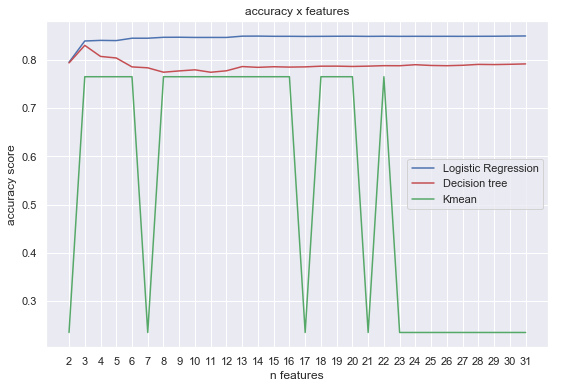

In [94]:
# Plontando o área de fundo
plt.figure(figsize=(9,6),facecolor = 'w',edgecolor = 'w')

# Plotando as linhas de accuracy x features para cada modelo
# Losgistic Regression
line1 = plt.plot(n_features_list, accuracy_LR, 'b', label='LR')
# Decision Tree
line2 = plt.plot(n_features_list, accuracy_dt, 'r', label= 'dt')
# Kmeans
line3 = plt.plot(n_features_list, accuracy_Kmeans, 'g', label= 'Kmean')

# Plotando as legendas
plt.legend(('Logistic Regression', 'Decision tree', 'Kmean'), loc = 'best')
# Titulo e nomes
plt.title('accuracy x features')
plt.ylabel('accuracy score')
plt.xlabel('n features')
# Linhas
plt.xticks(n_features_list)
plt.grid(b='true',which='both', axis='both')
plt.show()

Aqui podemos ver que os modelos tiveram com rendimento com 3 features de melhor valor **(RainToday, Rainfall e Humidity3pm)**, somente Kmeans que teve o mesmo rendimento com mais features. Vamos usar essa quantidade de 3 daqui para frente para compararmos os 3 modelos.
O próximo passo é determinar os melhores parâmetros para cada um dos métodos usando **GridSearchCV**, isso será aplicado para pelo menos 3 parâmetros.

In [97]:
# Separando os valores para o grupo de teste e trainamento com 3 features
X = df[K_values[:3]]
y = df['RainTomorrow']
features_train, features_test, labels_train, labels_test = train_test_split(X, y, test_size=0.2, random_state=42)

Para a Logistic Regression vamos ajustar os seguinte parâmetros:

* Solver - Algoritimos que otimizam o modelo (newton-cg, lbfgs, liblinear, sag, saga)
* C - O grau de força inversa para a regularização do sismtema $(0.01, 0.1, 10, 105,^10^{10}, 10^{15}, 10^{20})$
* tol - O critério de tolerancia para uma parada $(10^{-20}, 10^{-15}, 10^{-10}, 10^{-5}, 0.01, 0.1, 10)$

In [98]:
# Criando a lista de valores para cada parâmetro
parameters = {'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'), 'C':[0.01, 0.1, 10, 10**5,10**10,10**15,10**20],'tol':[10**-20,10**-15,10**-10,10**-5,0.01, 0.1, 10]}
# Aplicando o modelo
l_clf = LogisticRegression()
clf = GridSearchCV(l_clf, parameters)
clf.fit(features_train, labels_train)
# Retornando a melhor configuração para o medelo 
best_l_clf = clf.best_estimator_
clf.best_estimator_

C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed

C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the co

C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\Mari\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: Li

C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\Mari\Anaconda3\lib\site-packages\s

LogisticRegression(C=100000000000000000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='saga', tol=0.01, verbose=0, warm_start=False)

Para a Decision Tree vamos ajustar os seguinte parâmetros:

* Criterion - O critério que mede a qualidade de uma decisão em um nó (gini ou entropy)
* min_sample_leaf - A quantidade mínima de amostra necessária para um nó (1-5)
* max_depth - O quanto aprofundado vai ser essa decision tree. Ela pode chegar ao máximo das min_sample_leaf (1-5)
* class_weight - A determinação se cada feature vai ter um peso na tomada de decisão (balanced)

In [99]:
# Criando a lista de valores para os parâmetros 
parameters = { 'criterion': ('gini', 'entropy'), 'min_samples_leaf' : range(1, 5), 'max_depth' : range(1, 5), 'class_weight': ['balanced'] }
# Aplicando o modelo
dt_clf = DecisionTreeClassifier(random_state=0)
clf = GridSearchCV(dt_clf, parameters)
# Retornando a melhor configuração
clf.fit(features_train, labels_train)
clf.best_estimator_

C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=1, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

Para a Kmeans vamos ajustar os seguinte parâmetros:

* algorithm - o algoritimo que o modelo vai ultilizar para predição (auto, full, elkan)
* tol - Tolercancia relativa a inércia de convergência $(10^{-20},10^{-15},10^{-10},10^{-5},0.01, 0.1, 10)$
* n_init - número de interações que o modelo vai ultilizar para o centroide (10,25,50,75,100,200)

In [100]:
# Criando a lista de valores para os parâmetros 
parameters = {'algorithm':('auto', 'full', 'elkan'), 'tol':[10**-20,10**-15,10**-10,10**-5,0.01, 0.1, 10], 'n_init': [10,25,50,75,100,200], 'algorithm': ('auto', 'full', 'elkan')}
# Aplicando o modelo
k_clf = KMeans(n_clusters=2)
clf = GridSearchCV(k_clf, parameters)
# Retornando as configurações dos parâmetros
clf.fit(features_train, labels_train)
clf.best_estimator_

C:\Users\Mari\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=1e-20, verbose=0)

Agora com a otimização dos parâmetros para cada modelos vamos fazer a predição do tempo para chuva usando o método de validação.

Armazenando as configurações para cada modelo. Aqui veremos outros parâmentros não mencionados acima, eles são outra opções de ajustes. Como não foram avaliados, são retornados na forma padrão de cada modelo.

In [101]:
# Logistic Regression
l_clf = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='saga', tol=0.1,
          verbose=0, warm_start=False)

Em decision tree vamos adicionar o AdaBoostClassifier para tentar melhorar mais o resultado.

In [102]:
# Decision Tree com AdaBoost
dt_clf = AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'), n_estimators=50, learning_rate=.8)

In [103]:
# Kmean
k_clf =  KMeans(algorithm='elkan', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=1e-20, verbose=0)

O modelo de validação consiste em fazer mil interações dos modelos preditivos e retornar a accuracy, precision e recal para uma lista. Apartir dos resultados fazer uma média dos valores para possuir um valor mais real dos parâmetos de avaliação para determinar o melhor modelo.
O que permite fazer essas mil interações para validar os modelos é que a função **train_test_split** vai selecionar em cada interação um conjuto de dados diferente para teste e treinamento, assim podendo cobrir um quantidade maior de formações para que o modelo treine e gere resultados mais confiáveis, uma vez cobrindo combinações unicas.

Os parâmetro precision retorna a proporção de verdadeiros positivos nos registros de predição de chuva e descrevendo a frenquência de falsos negativos. Já recall demostra a proporção de verdadeiros positivos nos resultados de predição reais de chuva e descrevendo a sensibilidade dos resultados.
Esse dois métodos podem ajudar melhor em médotos de predição binários que somente accuracy evitando overfitings.

Criando a função de validação:

In [109]:

def avaliacao_clf(clf, features, labels, n_iters=1000):
    print (clf)
    
    # Criando as lista para receber os resultados
    accuracy = []
    precision = []
    recall = []
    first = True
    
    # Criando o loop de interação
    for tentativa in range(n_iters):
        
        # Separando os dados de treinamento e test
        features_train, features_test, labels_train, labels_test = train_test_split(X, y, test_size=0.3)
        Aplicando o métodos
        # Aplicando o medelo
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        # Retornando e armazenando accuracy
        accuracy.append(accuracy_score(labels_test, predictions))
        # Retornando e armazenando precision
        precision.append(precision_score(labels_test, predictions))
        # Retornando e armazendo recall
        recall.append(recall_score(labels_test, predictions))

    # Fazendo a média de métricas de avaliação e implementando os resultados

    print ("precision: {}".format(mean(precision)))
    print ("recall:    {}".format(mean(recall)))
    print ("accuracy:    {}".format(mean(accuracy)))
    
    return mean(precision), mean(recall), mean(accuracy)

Aplicando a função de avaliação para logistic regression:

In [111]:
avaliacao_clf(l_clf, X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='saga', tol=0.1,
          verbose=0, warm_start=False)
precision: 0.7129983218920188
recall:    0.37844887660411153
accuracy:    0.8374297147801365


(0.7129983218920188, 0.37844887660411153, 0.8374297147801365)

Aplicando a função de avaliação para Decision Tree:

In [112]:
avaliacao_clf(dt_clf, X, y)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          learning_rate=0.8, n_estimators=50, random_state=None)
precision: 0.45438754660510405
recall:    0.6940758597744313
accuracy:    0.7633000525323691


(0.45438754660510405, 0.6940758597744313, 0.7633000525323691)

Aplicando a função de avaliação para Kmeans:

In [113]:
avaliacao_clf(k_clf, X, y)

KMeans(algorithm='elkan', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=1e-20, verbose=0)
precision: 0.3665765933561321
recall:    0.4671008359716125
accuracy:    0.6377489570779642


(0.3665765933561321, 0.4671008359716125, 0.6377489570779642)

### Conclusão

Os resultados de accuracy, precision e recall do resultado de validação dos métodos encontrados na tabela abaixo:


| Algoritimo                | Precision   | Recall      | Accuracy    |
|---------------------------|-------------|-------------|-------------|
| Decision Tree - Adboost   | 0.454       | 0.694       | 0.763       |
| KMeans                    | 0.366       | 0.467       | 0.637       |
| Logistic Regression       | 0.721       | 0.378       | 0.837       |

A partir desses resultados podemos concluir que o modelo de Logistic Regression é a melhor opção dentro os modelos testas por ter os melhores resultados de precision, tendo o melhor rendimento em gerar verdadeiros positivos, recall, avaliando com precision tem o retorno de melhores resultado de dados corretos e accuracy melhor entre os três métodos.